In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
hsbc = pd.read_excel("data.xlsx", sheet_name="0005.HK")

In [3]:
hsbc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5781.000000,5781.000000,5781.000000,5781.000000,5781.000000,5.781000e+03
mean,84.617745,85.185656,84.075003,84.653648,52.600908,1.967983e+07
std,28.911357,28.992622,28.819455,28.914473,11.986123,1.731960e+07
min,28.350000,28.650000,27.500000,28.200001,18.757141,0.000000e+00
25%,63.849998,64.250000,63.500000,63.900002,44.202221,1.028607e+07
50%,81.050003,81.599998,80.599998,81.099998,50.651852,1.571686e+07
75%,102.000000,102.500000,101.000000,102.000000,59.877048,2.395947e+07
max,152.300003,153.500000,151.500000,152.800003,86.021988,5.747233e+08


In [4]:
hsbc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5783 entries, 0 to 5782
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5783 non-null   datetime64[ns]
 1   Open       5781 non-null   float64       
 2   High       5781 non-null   float64       
 3   Low        5781 non-null   float64       
 4   Close      5781 non-null   float64       
 5   Adj Close  5781 non-null   float64       
 6   Volume     5781 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 316.4 KB


In [5]:
null_sum = hsbc['Adj Close'].isnull().sum()
print(f"null before: {null_sum}")

hsbc['Adj Close'] = hsbc['Adj Close'].interpolate(method='linear')
hsbc.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

after_null_sum = hsbc.isnull().sum()
print(f"null after: {after_null_sum}")

hsbc['Month'] = hsbc['Date'].dt.month
hsbc['Day'] = hsbc['Date'].dt.dayofweek

null before: 2
null after: Date         0
Adj Close    0
dtype: int64


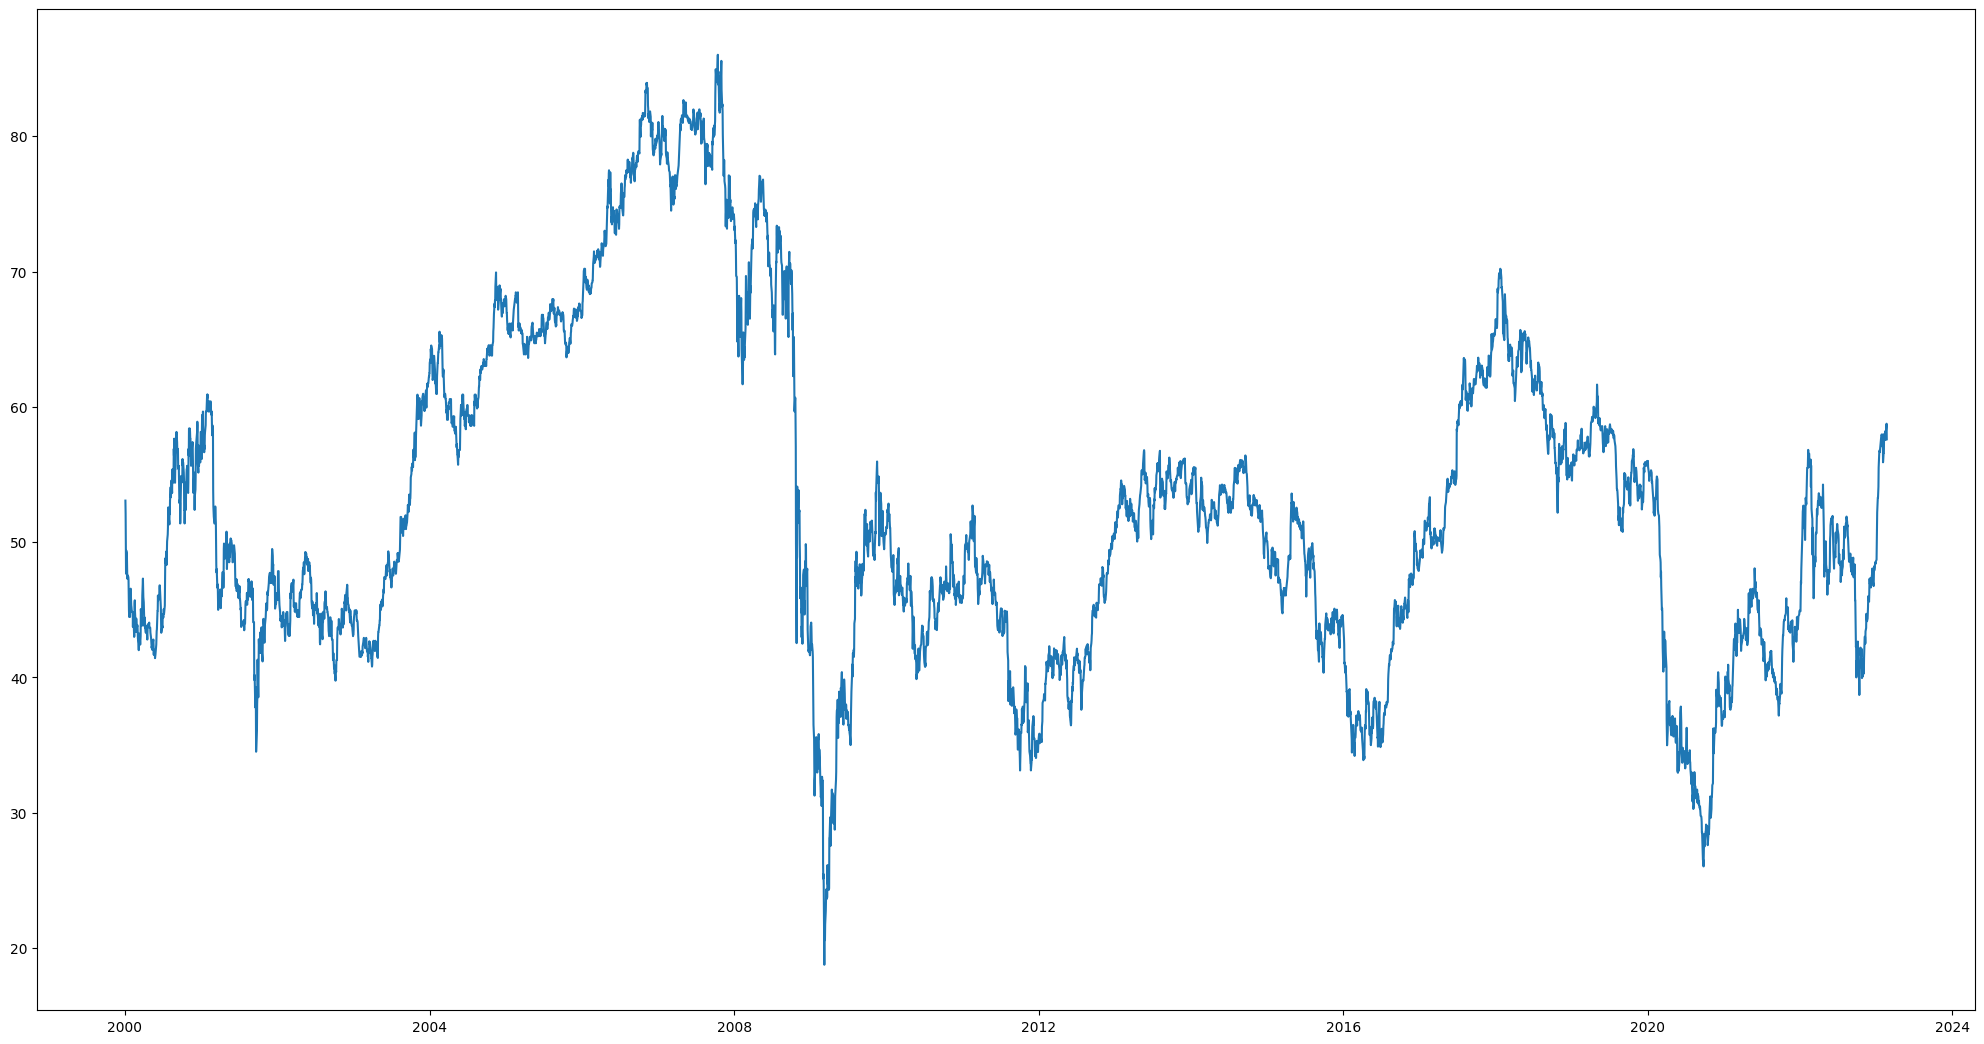

In [6]:
plt.figure(figsize=(25,13))
plt.plot(hsbc['Date'], hsbc['Adj Close'])

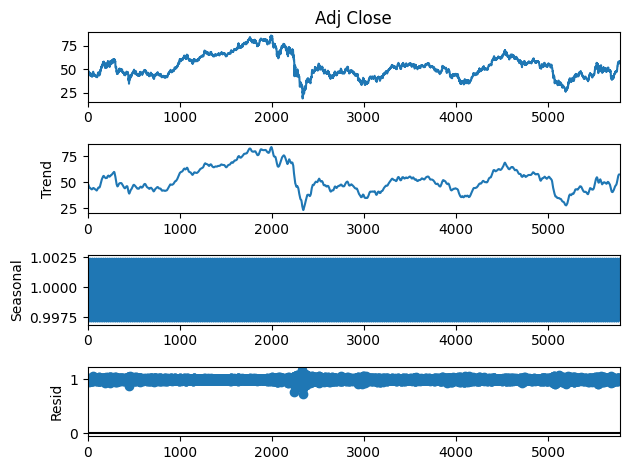

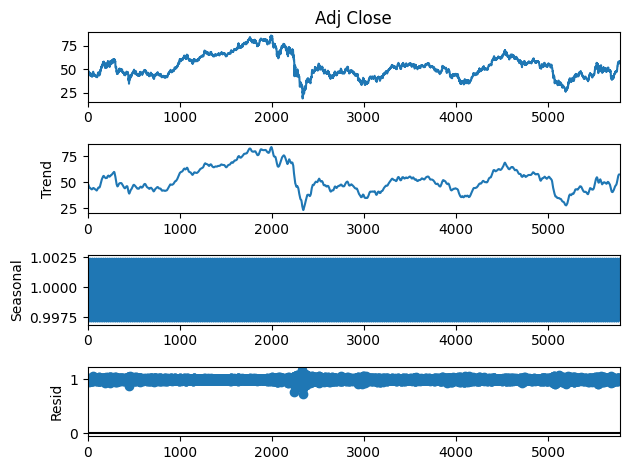

In [7]:
decompose = hsbc['Adj Close'].copy()
# checking seasonality in the price history (period: 5 trading days a week, 20 days a month, 253 days a year)
decompose_result_20 = seasonal_decompose(decompose, model="multiplicative", period=20) #period=5 also has full seasonal
decompose_result_20.plot()

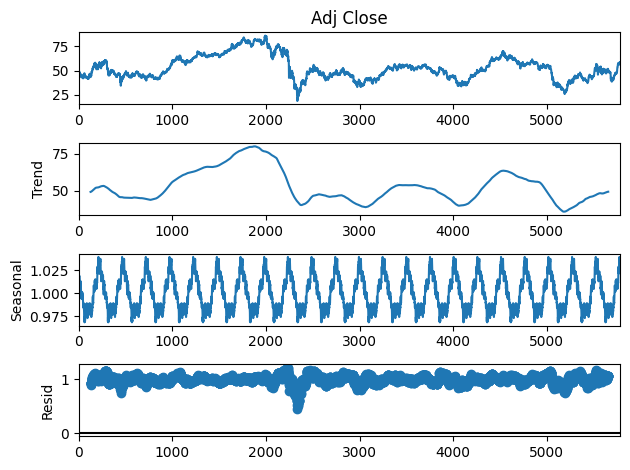

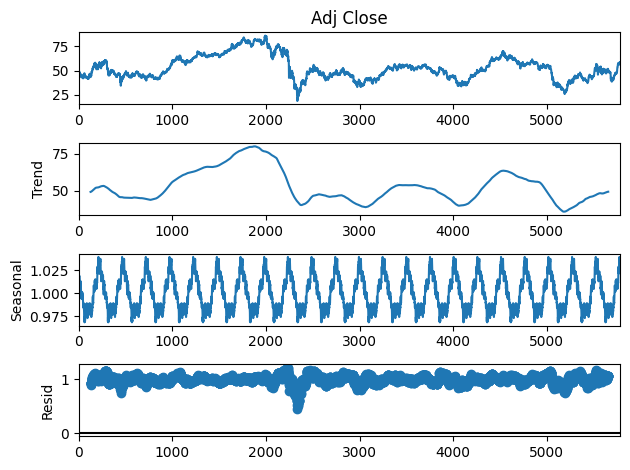

In [8]:
decompose_result_253 = seasonal_decompose(decompose, model="multiplicative", period=253) # clear yearly trend
decompose_result_253.plot()

In [9]:
# 20 trading days in a month (short term) and 253 trading days in a year (long term)
smas = [20, 253]
# 5 trading days in a week and 20 trading days in a month
emas = [5, 20]

def computeSMA(data, window):
    # simple moving average
    sma = data.rolling(window=window).mean()
    return sma

def computeEMA(data, span):
    # simple moving average
    ema = data.ewm(span=span, adjust=False).mean()
    return ema

def get_SMA_EMA(df):

    for sma in smas:
        df['SMA_{}'.format(sma)] = computeSMA(df['Adj Close'], sma)
    for ema in emas:
        df['EMA_{}'.format(ema)] = computeEMA(df['Adj Close'], ema)

    return df

def plot_data_SMA(df):
    plt.figure(figsize=(25,13))
    plt.title('Adj Close SMA')
    plt.plot(df['Date'], df['Adj Close'])

    for sma in smas:
        plt.plot(df['Date'], df['SMA_{}'.format(sma)], label='SMA {}'.format(sma))

    plt.legend(loc='best')
    plt.show()
    
    
def plot_data_EMA(df):
    plt.figure(figsize=(25,13))
    plt.title('Adj Close EMA')
    plt.plot(df['Date'], df['Adj Close'])

    for ema in emas:
        plt.plot(df['Date'], df['EMA_{}'.format(ema)], label='EMA {}'.format(ema))

    plt.legend(loc='best')
    plt.show()  

In [10]:
hsbc = get_SMA_EMA(hsbc)

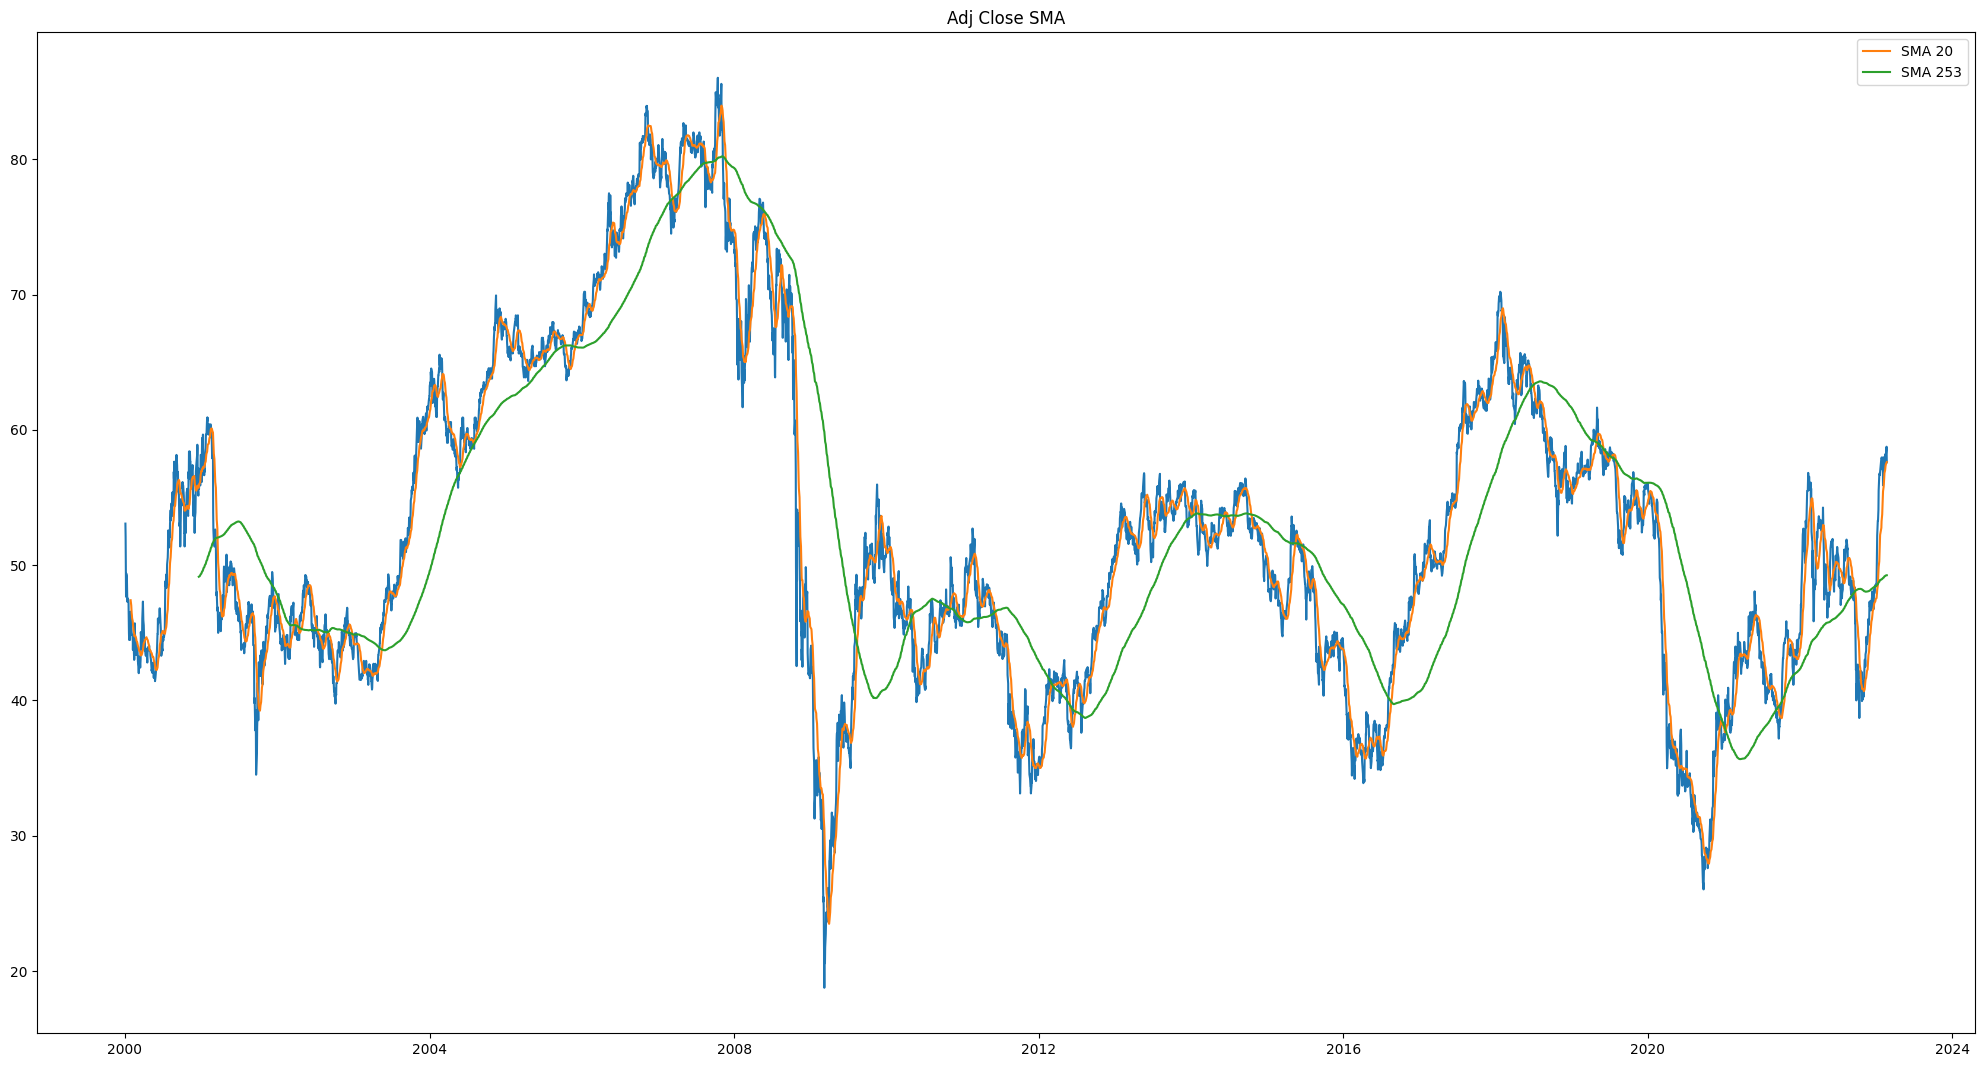

In [11]:
plot_data_SMA(hsbc)

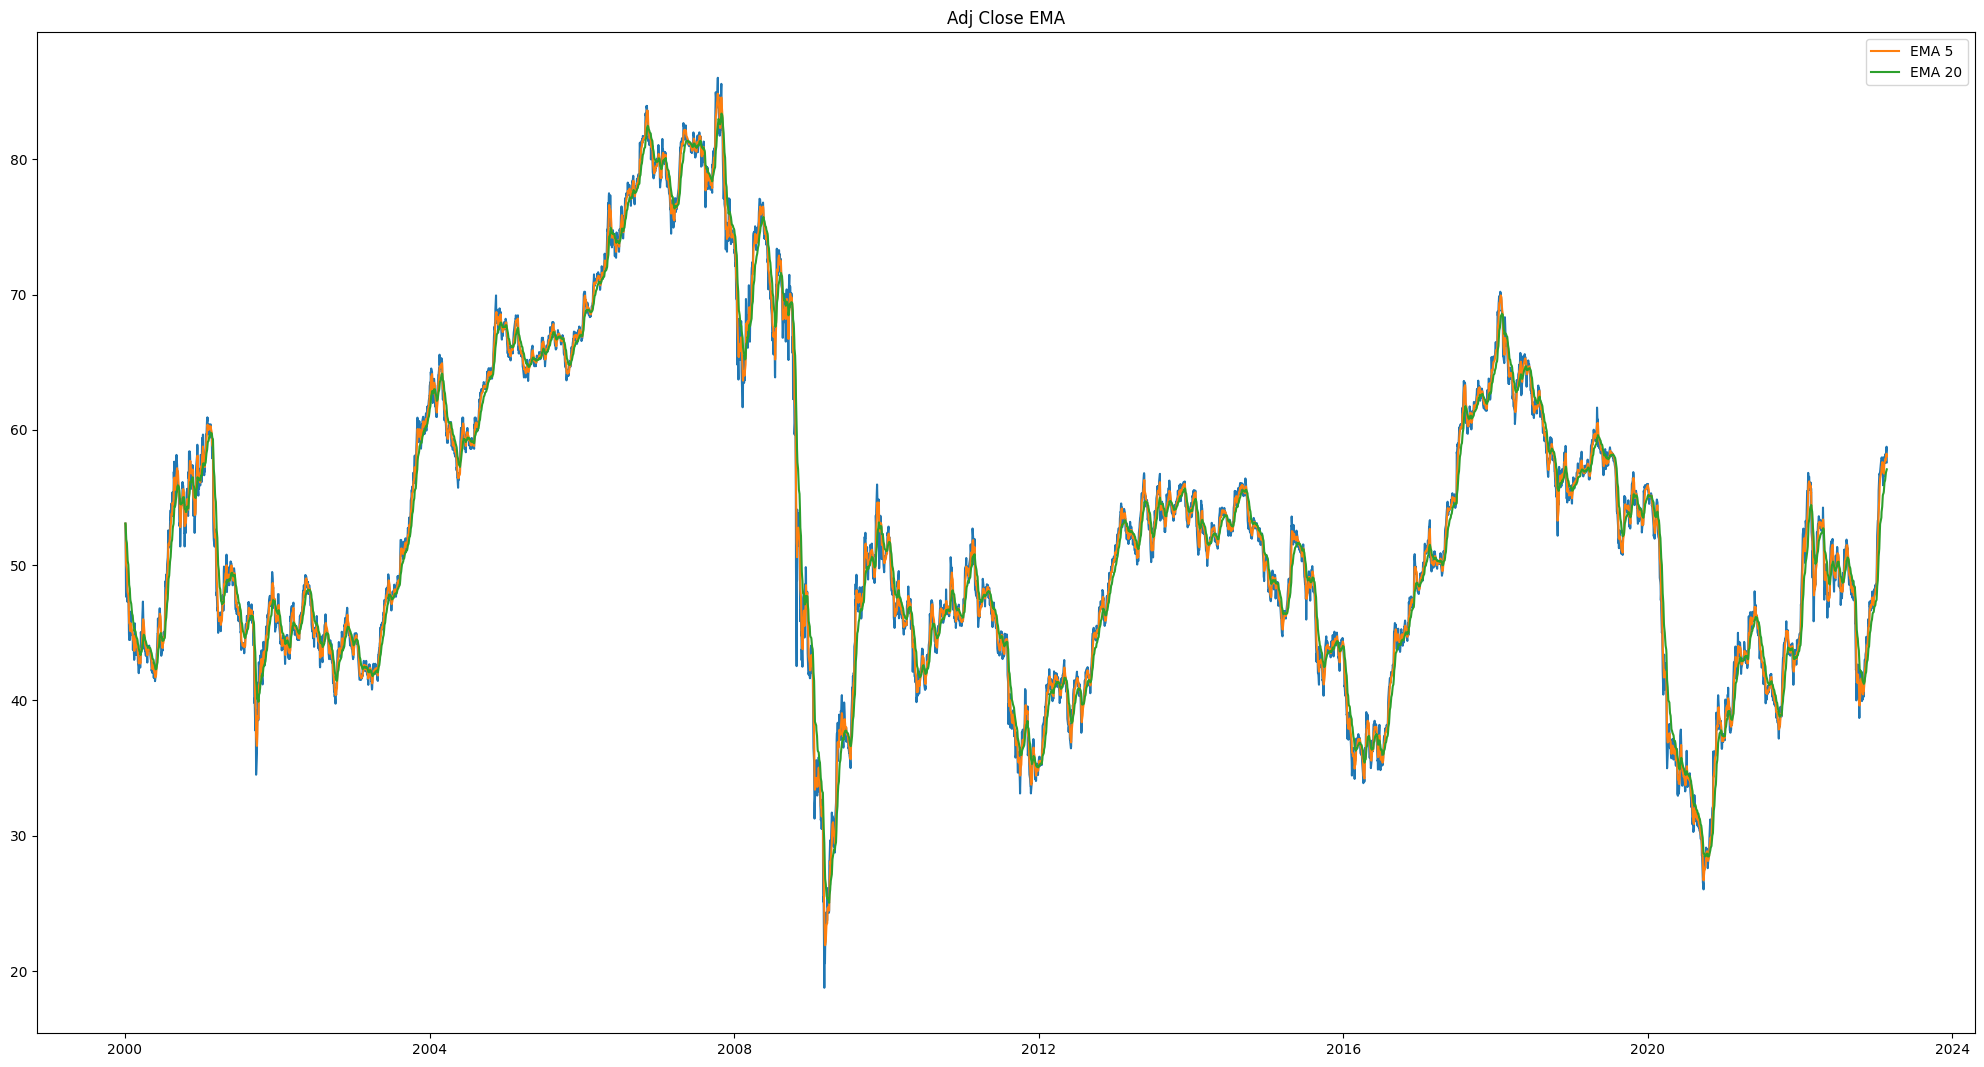

In [12]:
plot_data_EMA(hsbc)

In [13]:
hsbc_df = hsbc.copy()

# feature engineering to prepare data
hsbc_df = hsbc_df.rename(columns={'Adj Close': f'Price'})
hsbc_df['Lag1_Price'] = hsbc_df['Price'].shift(1) # create feature of past 1-day price
hsbc_df['Lag2_Price'] = hsbc_df['Price'].shift(2) # past 2-days price

# features: SMA_20, SMA_253, EMA_5, EMA_20, Lag1_Price, Lag2_Price, Month, DayOfWeek
hsbc_df.dropna(inplace=True)
hsbc_df = hsbc_df.loc[:, ['Date', 'Month', 'Day', 'SMA_20', 'SMA_253',
                            'EMA_5', 'EMA_20', 'Lag1_Price', 'Lag2_Price', 
                            'Price']]

# one-hot encode the Month and Day columns
month_one_hot = pd.get_dummies(hsbc_df['Month'], prefix='month')
day_one_hot = pd.get_dummies(hsbc_df['Day'], prefix='day')

# concatenate the one-hot encoded columns to the original dataset
hsbc_df = pd.concat([hsbc_df, month_one_hot, day_one_hot], axis=1)

hsbc_df = hsbc_df.set_index(hsbc_df['Date'])
hsbc_df.drop(columns=['Date', 'Month', 'Day'], axis=1, inplace=True)

train_df = hsbc_df.loc[:'2023-01-01']
test_df = hsbc_df.loc['2022-12-01':] #include 20 days before

In [14]:
X_train = train_df.drop('Price', axis=1)
y_train = train_df['Price']

X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

In [15]:
# scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create sequences of data using TimeseriesGenerator
sequence_length = 20
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=32)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=32)

In [16]:
# function to calculate MAPE
def calculate_mape(y, y_pred):
    
  y_np = np.array(y)
  y_pred_np = np.array(y_pred)

  return round(np.mean(np.abs((y_np - y_pred_np) / y_np)) * 100, 4)

In [17]:
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [21]:
# defining the model architecture
model = Sequential()

# adding LSTM layers
model.add(LSTM(units=64, input_shape=(sequence_length, X_train.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=32))
model.add(Dropout(0.1))

# adding dense layer
model.add(Dense(units=1))

# compiling the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# training the model
model.fit(train_generator, epochs=100, validation_data=test_generator)

Epoch 1/100
172/172 [==============================] - 10s 15ms/step - loss: 2123.0293 - val_loss: 1896.1176
Epoch 2/100
172/172 [==============================] - 2s 10ms/step - loss: 1549.8396 - val_loss: 1455.6366
Epoch 3/100
172/172 [==============================] - 2s 10ms/step - loss: 1196.8259 - val_loss: 1113.5356
Epoch 4/100
172/172 [==============================] - 2s 10ms/step - loss: 920.7339 - val_loss: 844.4114
Epoch 5/100
172/172 [==============================] - 2s 10ms/step - loss: 710.8880 - val_loss: 632.2557
Epoch 6/100
172/172 [==============================] - 2s 10ms/step - loss: 548.4499 - val_loss: 468.0226
Epoch 7/100
172/172 [==============================] - 2s 10ms/step - loss: 426.2812 - val_loss: 342.8247
Epoch 8/100
172/172 [==============================] - 2s 10ms/step - loss: 338.8062 - val_loss: 249.5804
Epoch 9/100
172/172 [==============================] - 2s 10ms/step - loss: 276.3652 - val_loss: 179.1104
Epoch 10/100
172/172 [=================

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            22784     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [21]:
def eval_train_score(model, train_input, y_train):
    y_train_pred = model.predict(train_input).flatten()
    y_train_actual = np.array(y_train[sequence_length:])
    mape = calculate_mape(y_train_actual, y_train_pred)

    return mape

def eval_test_score(model, test_input, y_test):
    y_test_pred = model.predict(test_input).flatten()
    y_test_actual = np.array(y_test[sequence_length:])
    mape = calculate_mape(y_test_actual, y_test_pred)

    return y_test_pred, y_test_actual, mape

def plot_test(y_actual, y_pred):
    plt.title('Test Predictions')
    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show() # plotting prediction on test and actual prices

In [24]:
print("Train MAPE: ", eval_train_score(model, train_generator, y_train))

172/172 [==============================] - 1s 6ms/step
Train MAPE:  1.9117


2/2 [==============================] - 0s 16ms/step
Test MAPE:  3.1884


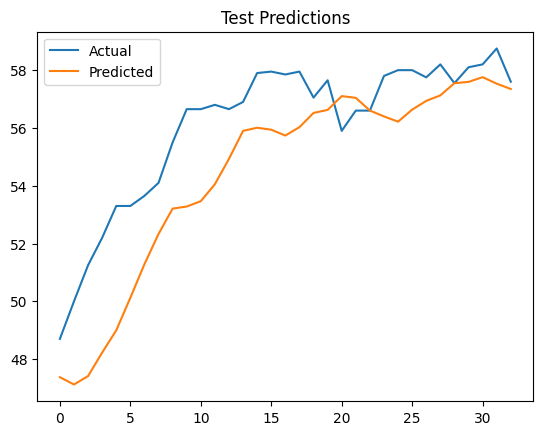

In [28]:
y_pred, y_actual, test_mape = eval_test_score(model, test_generator, y_test)
print("Test MAPE: ", test_mape)
plt.title('Test Predictions')
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show() # plotting prediction on test and actual prices

In [18]:
def build_model(hp):
        model = Sequential()
        model.add(LSTM(hp.Int('lstm_0_units',min_value=64,max_value=128,step=32),return_sequences=True, input_shape=(sequence_length, X_train.shape[1])))
        model.add(Dropout(hp.Float('dropout',min_value=0.1,max_value=0.5,step=0.1)))

        model.add(LSTM(hp.Int(f'lstm_1_units',min_value=32,max_value=64,step=32),return_sequences=True))
        model.add(Dropout(hp.Float('dropout',min_value=0.1,max_value=0.5,step=0.1)))

        model.add(LSTM(units=32))
        model.add(Dropout(hp.Float('dropout',min_value=0.1,max_value=0.5,step=0.1)))

        model.add(Dense(units=1))

        optimizer = Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log'))

        model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

        return model

K.clear_session()

tuner= kt.RandomSearch(
        build_model,
        objective='val_mse',
        max_trials=10,
        executions_per_trial=3,
        directory='tuned_model',
        project_name='lstm_hsbc_tuned',
        overwrite=True
        )

tuner.search(
        train_generator,
        epochs=100,
        validation_data=test_generator,
)


Trial 10 Complete [00h 12m 40s]
val_mse: 15.998018900553385

Best val_mse So Far: 1.8494081497192383
Total elapsed time: 01h 52m 24s
INFO:tensorflow:Oracle triggered exit


In [19]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            22784     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

172/172 [==============================] - 2s 5ms/step
Train MAPE:  2.8765
2/2 [==============================] - 0s 6ms/step
Test MAPE:  1.575


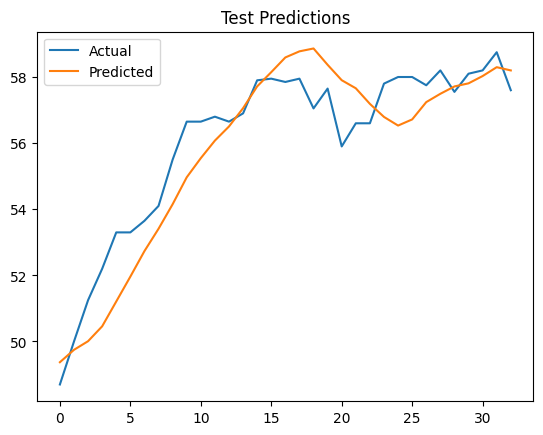

In [22]:
print("Train MAPE: ", eval_train_score(best_model, train_generator, y_train))
y_pred, y_actual, test_mape = eval_test_score(best_model, test_generator, y_test)
print("Test MAPE: ", test_mape)
plt.title('Test Predictions')
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show() # plotting prediction on test and actual prices

In [24]:
best_model.save('lstm_hsbc_tuned.h5')
# model = load_model('lstm_hsbc.h5')

In [25]:
future_dates = pd.date_range(start='2023-02-22', end='2023-03-17', freq='B') #generate only trading days, excluding holidays
future_dates

DatetimeIndex(['2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27',
               '2023-02-28', '2023-03-01', '2023-03-02', '2023-03-03',
               '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',
               '2023-03-10', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17'],
              dtype='datetime64[ns]', freq='B')

In [26]:
# predicting future prices by calculating each features one-by-one and iteratively predicting the next day price
history_train_df = train_df.copy()
history_train_df = history_train_df.loc[:, ['SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'Lag1_Price', 'Lag2_Price', 'Price']]

history_test_df = test_df.drop('Price', axis=1)
history_test_df = history_test_df.loc['2023-01-01':]
history_test_df['Price'] = y_pred # add the predicted price from before
history_test_df = history_test_df.loc[:, ['SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'Lag1_Price', 'Lag2_Price', 'Price']]

history_pred_df = pd.concat([history_train_df, history_test_df])

for date in future_dates:
    target_date = date
    print(target_date)

    # get the previous 20 days of data and calculate the SMA_20
    prev_20_days = history_pred_df.loc[:target_date].tail(20)
    SMA_20 = computeSMA(prev_20_days['Price'], window=20)[-1]

    # get the previous 253 days of data and calculate the SMA_253
    prev_253_days = history_pred_df.loc[:target_date].tail(253)
    SMA_253 = computeSMA(prev_253_days['Price'], window=253)[-1]

    # get the previous 5 days of data and calculate the EMA_5
    prev_5_days = history_pred_df.loc[:target_date].tail(5)
    EMA_5 = computeEMA(prev_5_days['Price'], span=5)[-1]

    # get the previous 20 days of data and calculate the EMA_20
    prev_20_days = history_pred_df.loc[:target_date].tail(20)
    EMA_20 = computeEMA(prev_20_days['Price'], span=20)[-1]

    # assign Lag1_Price as the predicted price for the previous business day
    lag1_date = pd.date_range(end=target_date, periods=2, freq='B')[0]
    lag1_df = history_pred_df.loc[history_pred_df.index <= lag1_date]
    Lag1_Price = lag1_df.iloc[-1]['Price']

    # assign Lag2_Price as the predicted price for two business days ago
    lag2_date = pd.date_range(end=target_date, periods=3, freq='B')[0]
    lag2_df = history_pred_df.loc[history_pred_df.index <= lag2_date]
    Lag2_Price = lag2_df.iloc[-1]['Price']

    # create a DataFrame for the features of the target date
    X_features_date = pd.DataFrame({
        'SMA_20': [SMA_20],
        'SMA_253': [SMA_253],
        'EMA_5': [EMA_5],
        'EMA_20': [EMA_20],
        'Lag1_Price': [Lag1_Price],
        'Lag2_Price': [Lag2_Price],
    }, index=[target_date])

    X_prev_20_days = prev_20_days.drop('Price', axis=1)

    X_features_forecast = pd.concat([X_prev_20_days, X_features_date])
    X_features_forecast.reset_index(inplace=True)
    X_features_forecast = X_features_forecast.rename(columns = {'index':'Date'})
    X_features_forecast['Month'] = X_features_forecast['Date'].dt.month
    X_features_forecast['Day'] = X_features_forecast['Date'].dt.dayofweek

    # Create an empty DataFrame with columns for all one-hot encoded features
    one_hot_cols = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5']
    if target_date.month == 2:
        remained_one_hot_cols = ['month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_5']
    else:
        remained_one_hot_cols = [ 'month_1', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_5']

    # one-hot encode the Month and Day columns
    month_one_hot = pd.get_dummies(X_features_forecast['Month'], prefix='month')
    day_one_hot = pd.get_dummies(X_features_forecast['Day'], prefix='day')

    # combine one-hot encoded dataframes
    one_hot_df = pd.concat([month_one_hot, day_one_hot], axis=1)
    one_hot_df.head()
    for col in remained_one_hot_cols:
        one_hot_df[col] = 0

    one_hot_df = one_hot_df[one_hot_cols]

    # concatenate the one-hot encoded columns to the original dataset
    X_features_forecast = pd.concat([X_features_forecast, one_hot_df], axis=1)

    # preparing features for prediction
    X_features_forecast = X_features_forecast.set_index(X_features_forecast['Date'])
    X_features_forecast.drop(columns=['Date', 'Month', 'Day'], axis=1, inplace=True)

    date_index = []
    X_forecast = []

    for i in range(len(X_features_forecast)-sequence_length+1):
        X_forecast.append(X_features_forecast.iloc[i:i+sequence_length].values)
        date_index.append(X_features_forecast.index[i+sequence_length-1])
        
    X_forecast = np.array(X_forecast)
    date_index = np.array(date_index)

    X_forecast = X_forecast.reshape(-1, X_train.shape[-1])
    # ccale the X_feature_forecasts data
    X_features_forecast_scaled = scaler.transform(X_forecast)

    sequence_length = 20

    # create a TimeseriesGenerator object for X_feature_forecasts
    feature_generator = TimeseriesGenerator(X_features_forecast_scaled, np.zeros(len(X_features_forecast_scaled)), length=sequence_length, batch_size=1)

    # predict next day price
    predicted_price = best_model.predict(feature_generator)

    # get last day of the prediction
    X_features_date['Price'] = predicted_price[-1][-1]
    history_pred_df = pd.concat([history_pred_df, X_features_date])
    print("===================== done adding ================")


2023-02-22 00:00:00
20/20 [==============================] - 0s 9ms/step
===================== done adding ================
2023-02-23 00:00:00
20/20 [==============================] - 0s 8ms/step
===================== done adding ================
2023-02-24 00:00:00
20/20 [==============================] - 0s 7ms/step
===================== done adding ================
2023-02-27 00:00:00
20/20 [==============================] - 0s 6ms/step
===================== done adding ================
2023-02-28 00:00:00
20/20 [==============================] - 0s 6ms/step
===================== done adding ================
2023-03-01 00:00:00
20/20 [==============================] - 0s 6ms/step
===================== done adding ================
2023-03-02 00:00:00
20/20 [==============================] - 0s 6ms/step
===================== done adding ================
2023-03-03 00:00:00
20/20 [==============================] - 0s 6ms/step
===================== done adding ================
2023-03-

In [27]:
dates_2023 = history_pred_df.loc['2023-01-01':]
observed_period = dates_2023.loc[:'2023-02-21']
forecast_period = dates_2023.loc['2023-02-22':'2023-03-17']

In [28]:
forecast_period['Price']

2023-02-22    58.164291
2023-02-23    58.042709
2023-02-24    58.190350
2023-02-27    58.445778
2023-02-28    58.320786
2023-03-01    58.244171
2023-03-02    58.072617
2023-03-03    58.261322
2023-03-06    58.733696
2023-03-07    59.085255
2023-03-08    59.373043
2023-03-09    59.554626
2023-03-10    59.946342
2023-03-13    60.429798
2023-03-14    60.703102
2023-03-15    60.904320
2023-03-16    61.015179
2023-03-17    61.364380
Name: Price, dtype: float64

In [29]:
# calculate residuals from observed period
residuals = sorted([x - y for x, y in zip(y_pred, y_actual)])

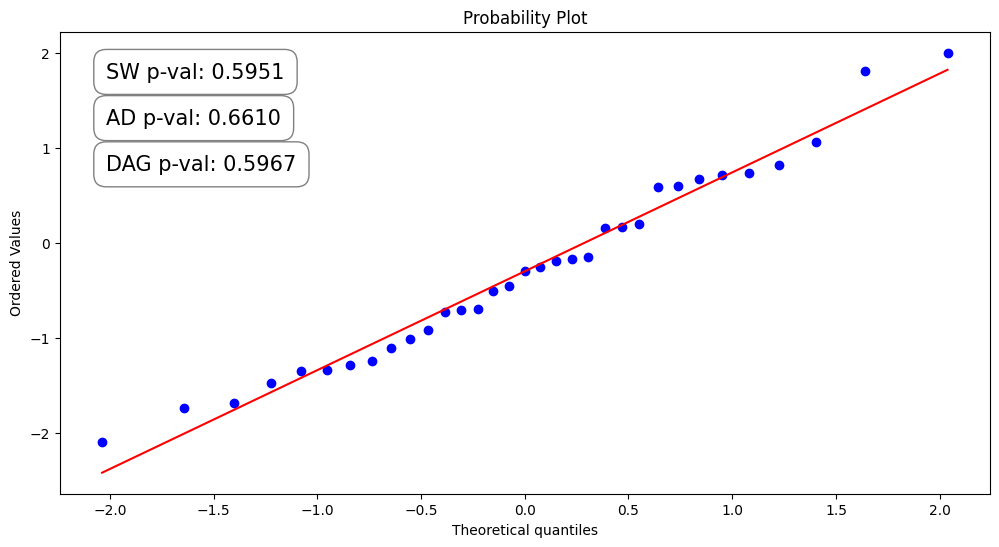

In [30]:
# check normal dist from residuals using smirnov-kolmogorov, anderson-darling, d'agostino k-squared tests
# reference: https://towardsdatascience.com/time-series-forecasting-prediction-intervals-360b1bf4b085
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(12, 6))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

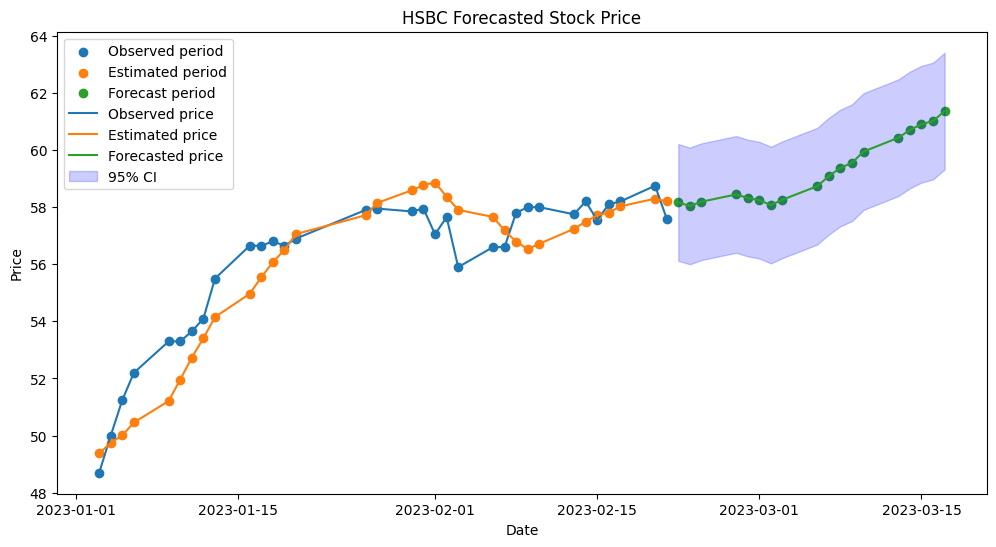

In [31]:
# plotting result for Task 3
forecast_price = np.array(forecast_period['Price'])

# create a scatter plot with Price on the y-axis and Date on the x-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(observed_period.index, y_actual, label='Observed period')
ax.scatter(observed_period.index, observed_period['Price'], label='Estimated period')
ax.scatter(forecast_period.index, forecast_period['Price'], label='Forecast period')

# add lines for the observed period and forecast period
ax.plot(observed_period.index, y_actual, label='Observed price')
ax.plot(observed_period.index, observed_period['Price'], label='Estimated price')
ax.plot(forecast_period.index, forecast_period['Price'], label='Forecasted price')

# creating 95% CI
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
se = 1.96*RMSFE
upper_bound = forecast_price + se
lower_bound = forecast_price - se
ax.fill_between(forecast_period.index, upper_bound, lower_bound, alpha=0.2, label='95% CI', color='b')

ax.set_title('HSBC Forecasted Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

plt.show()